Importing the modules

In [107]:
from warnings import simplefilter
simplefilter(action='ignore')
import cv2 as cv
from PIL import Image
import shutil
import ast
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd
import numpy as np
import sympy as sympy
import time
import enum
import ast
import json
from pathlib import Path
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import  torchvision.transforms as transforms
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, RandomResizedCrop, RandomHorizontalFlip
from torchinfo import summary


In [55]:
train_annotations = pd.read_csv("C:/Users/toonb/ADS2002/catheter2025/train_annotations.csv")
train_data = pd.read_csv("C:/Users/toonb/ADS2002/catheter2025/train.csv")
all_images_dir = "C:/Users/toonb/ADS2002/catheter2025/train"
train_dir = "C:/Users/toonb/ADS2002/catheter2025/trainsplit"
test_dir = "C:/Users/toonb/ADS2002/catheter2025/testsplit"
# Merge on 'StudyInstanceUID' to add the PatientID column
df = train_annotations.merge(train_data[['StudyInstanceUID', 'PatientID']], on='StudyInstanceUID', how='left')

#Convert string to list of lists in data column
df['data'] = df['data'].apply(lambda x: ast.literal_eval(x))

#Drop all rows which are incompletely imaged NGTs or Swan Ganz catheters
df = df[~df['label'].isin(['NGT - Incompletely Imaged', 'Swan Ganz Catheter Present'])]

# Split the 'full_name' column into 'first_name' and 'last_name'
df[['type', 'position']] = df['label'].str.split('-', expand=True)
df.drop(columns=['label'], inplace=True)
df.head()

,StudyInstanceUID,data,PatientID,type,position
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,"[[1487, 1279], [1477, 1168], [1472, 1052], [14...",ac2e8d106,CVC,Normal
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2...",ac2e8d106,CVC,Normal
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,"[[801, 1207], [812, 1112], [823, 1023], [842, ...",35ac6438a,CVC,Borderline
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,"[[1366, 961], [1411, 861], [1453, 751], [1508,...",156d90dd4,CVC,Normal
4,1.2.826.0.1.3680043.8.498.87704688663091069148...,"[[1862, 14], [1845, 293], [1801, 869], [1716, ...",26da0d5ad,NGT,Normal


In [3]:
#Retrieve all IDs of each unqiue image
unique_images = df['StudyInstanceUID'].unique()

#80/20 train test split on just the unique image IDs
train_ids, test_ids = train_test_split(
    unique_images,
    test_size=0.2,
    random_state=3,
    stratify=df.drop_duplicates('StudyInstanceUID')["type"]
)

#Create train and test dataframes with a mask that uses the image IDs found above
train_df = df[df['StudyInstanceUID'].isin(train_ids)]
test_df  = df[df['StudyInstanceUID'].isin(test_ids)]

In [4]:
#Make sure that the train/test folders exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

#Function to move images from all_images to dest_dir, guided by the split that has been applied to the dataframe
def move_images(df, dest_dir):
    k=0
    for fname in tqdm(df["StudyInstanceUID"].unique(), desc=f"Moving to {os.path.basename(dest_dir)}"):
        src = os.path.join(all_images_dir, fname + ".jpg")
        dst = os.path.join(dest_dir, fname + ".jpg")
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            k+=1
    return k

#Apply the function to both the train and test images
move_images(train_df, train_dir)
move_images(test_df, test_dir)
# print(f"Skipped {move_images(train_df, train_dir)} image IDs in train_df")
# print(f"Skipped {move_images(test_df, test_dir)} image IDs in test_df")

Moving to testsplit: 100%|██████████| 1814/1814 [00:04<00:00, 441.25it/s]


0

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

epochs = 40
batch_size = 32
num_workers = 2
logging = "/content/drive/MyDrive/ADS2002PROJECT/logging"

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
size = 224

train_transform = Compose([
                ToPILImage(),
                RandomResizedCrop(224, scale=(0.5,1.0)),
                RandomHorizontalFlip(),
                ToTensor(),
                Normalize(mean, std)
            ])
test_transform = Compose([
                ToPILImage(),
                Resize((224, 224)),
                ToTensor(),
                Normalize(mean, std)
            ])

In [6]:
x_train=[]

#Loop over all images IDs in the train folder
for fname in tqdm(os.listdir(rf'{train_dir}')):
    #Retrieve the image based on its ID
    image_path = rf'{train_dir}'+rf'/{fname}'
    # img = Image.open(rf'{train_dir}'+rf'/{fname}')
    image = cv2.imread(image_path)
    #Resize the image
    img = train_transform(image)
    #Add the image to our list
    x_train.append(img)

100%|██████████| 7254/7254 [08:00<00:00, 15.09it/s]


In [7]:

x_test=[]

#Loop over all images IDs in the train folder
for fname in tqdm(os.listdir(rf'{test_dir}')):
    #Retrieve the image based on its ID
    image_path = rf'{test_dir}'+rf'/{fname}'
    # img = Image.open(rf'{train_dir}'+rf'/{fname}')
    image = cv2.imread(image_path)
    #Resize the image
    img = test_transform(image)
    #Add the image to our list
    x_test.append(img)

100%|██████████| 1814/1814 [02:03<00:00, 14.65it/s]


In [8]:
#Convert PIL images to numpy arrays and normalize the pixel values
x_train = np.array([np.array(img, dtype=np.float32) for img in x_train])
x_test  = np.array([np.array(img, dtype=np.float32) for img in x_test])

# #Add channel dimension so the conv2D layer in the model can work
# x_train = np.expand_dims(x_train, axis=-1)  #shape is (7254, 32, 32, 1)
# x_test = np.expand_dims(x_test, axis=-1)   #shape is (1814, 32, 32, 1)

In [9]:
x_train.shape

(7254, 3, 224, 224)

In [10]:
#Create a dataframe which has only one row per image. This loses almost half of the rows and may create biases.
train_df_unique_images = train_df.drop_duplicates(subset=['StudyInstanceUID'])

y_train = []

# #Loop over all image IDs in train folder
for fname in tqdm(os.listdir(rf'{train_dir}')):
  #Retrieve the catheter type that corresponds to the image ID
  label = train_df_unique_images.loc[train_df_unique_images['StudyInstanceUID'] == fname[:-4], 'type']

  #Add the label to our list
  y_train.append(label)


100%|██████████| 7254/7254 [00:06<00:00, 1083.90it/s]


In [11]:
#Create a dataframe which has only one row per image. This loses almost half of the rows and may create biases.
test_df_unique_images = test_df.drop_duplicates(subset=['StudyInstanceUID'])

y_test = []

#Loop over all images in test folder
for fname in tqdm(os.listdir(rf'{test_dir}')):
  #Retrieve the catheter type that corresponds to the image ID
  label = test_df_unique_images.loc[test_df_unique_images['StudyInstanceUID'] == fname[:-4], 'type']

  #Add the label to our list
  y_test.append(label)

100%|██████████| 1814/1814 [00:00<00:00, 2390.34it/s]


In [12]:
#Instantiate the label encoder
le = LabelEncoder()

#Transform the strings to integers
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [13]:
# class VVG16_net(nn.Module):
#     def __init__(self, in_channels=3, n_classes=10):
#         super().__init__()
#         self.in_channels = in_channels
#         self.conv1 = self.conv_block(in_channels=self.in_channels, block=[64, 64])
#         self.conv2 = self.conv_block(in_channels=64, block=[128, 128])
#         self.conv3 = self.conv_block(in_channels=128, block=[256, 256, 256])
#         self.conv4 = self.conv_block(in_channels=256, block=[512, 512, 512])
#         self.conv5 = self.conv_block(in_channels=512, block=[512, 512, 512])
#         self.fcs = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(512*7*7, 4096),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, n_classes)
#         )

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.conv5(x)
#         x = self.fcs(x)
#         return x

#     def conv_block(self, in_channels ,block):
#         layers = []
#         for i in block:
#             layers += [nn.Conv2d(in_channels=in_channels, out_channels=i, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#                        nn.BatchNorm2d(i),
#                        nn.ReLU()]
#             in_channels = i
#         layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
#         return nn.Sequential(*layers)

In [14]:
class CatheterDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.image_paths = []
        self.labels = []
        self.categories = list(df['type'].unique())

        self.transform = transform


        if train == True:
            for i, category in enumerate(self.categories):
                for item in os.listdir(train_dir):
    
                    path = os.path.join(train_dir, item)
                    
                    # Extract category from filename (e.g., 'cat_001.jpg' → 'cat')
                    category_object = df.loc[df['StudyInstanceUID'] == item[:-4], 'type']
                    for x in category_object:
                        category = x
                    # Map category to label index  
                    if category not in self.categories:
                        self.categories.append(category)
                    label = self.categories.index(category)
    
                    self.image_paths.append(path)
                    self.labels.append(label)
        else:
            for i, category in enumerate(self.categories):
                for item in os.listdir(test_dir):
    
                    path = os.path.join(test_dir, item)
                    
                    # Extract category from filename (e.g., 'cat_001.jpg' → 'cat')
                    category_object = df.loc[df['StudyInstanceUID'] == item[:-4], 'type']
                    for x in category_object:
                        category = x
                    # Map category to label index  
                    if category not in self.categories:
                        self.categories.append(category)
                    label = self.categories.index(category)
     
                    self.image_paths.append(path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [15]:
train_dataset = CatheterDataset(True,train_transform)
test_dataset = CatheterDataset(False,test_transform)

In [16]:
train_dataloader = DataLoader(dataset=(train_dataset), batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(dataset=(test_dataset), batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [17]:

# model = VVG16_net().to(device)
# if os.path.exists('C:/Users/toonb/ADS2002/catheter2025/model/last.pt'):
#   if torch.cuda.is_available():
#     model.load_state_dict(torch.load('C:/Users/toonb/ADS2002/catheter2025/model/last.pt'))
#   else:
#     model.load_state_dict(torch.load('C:/Users/toonb/ADS2002/catheter2025/model/last.pt', map_location=torch.device('cpu')))
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9) #optim.Adam(model.parameters(), lr=1e-3)
# best_acc = 0.8871

In [18]:
# summary(model)

In [19]:

# for epoch in range(epochs):
#     model.train()
#     progress_bar = tqdm(train_dataloader)
#     print(progress_bar)
#     for iter, (images, labels) in enumerate(progress_bar):
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         # writer.add_scalar('Train/Loss', loss, epoch*len(train_dataloader)+iter)
#         progress_bar.set_description('Epoch: {}/{} Iter: {} Loss: {:.4f}'.format(epoch+1, epochs, iter+1, loss.item()))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     model.eval()
#     all_predictions = []
#     all_labels = []
#     for iter, (images, labels) in enumerate(test_dataloader):
#         images = images.to(device)
#         labels = labels.to(device)

#         with torch.no_grad():
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             predictions = torch.argmax(outputs.cpu(), dim=1)
#             all_predictions.extend(predictions)
#             all_labels.extend(labels.cpu())
#     all_labels = [label.item() for label in all_labels]
#     all_predictions = [prediction.item() for prediction in all_predictions]
#     acc = accuracy_score(all_labels, all_predictions)
#     print('Epoch: {}/{} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch+1, epochs, loss.item(), acc))
#     torch.save(model.state_dict(), 'C:/Users/toonb/ADS2002/catheter2025/model/last.pt')
#     if acc > best_acc:
#         torch.save(model.state_dict(), 'C:/Users/toonb/ADS2002/catheter2025/model/best.pt')
#         best_acc=acc
#     # writer.add_scalars('Val/Accuracy', acc, epoch)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32) / 255.0  # Normalize to [0,1]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


In [21]:

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [22]:

X_train = x_train # if not already a NumPy array
Y_train = y_train
X_test = x_test
Y_test = y_test

In [23]:
X_train.shape

(7254, 3, 224, 224)

In [24]:
dataset2 = ImageDataset(X_test,Y_test)
test_loader = DataLoader(dataset2,batch_size=32,shuffle=False,num_workers=0)

In [25]:

num_classes = len(np.unique(Y_train))
dataset = ImageDataset(X_train, Y_train)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [26]:
summary(model)

Layer (type:depth-idx)                   Param #
SimpleCNN                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       18,496
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Flatten: 2-7                      --
│    └─Linear: 2-8                       25,690,240
│    └─ReLU: 2-9                         --
│    └─Dropout: 2-10                     --
│    └─Linear: 2-11                      387
Total params: 25,710,019
Trainable params: 25,710,019
Non-trainable params: 0

In [27]:
num_epochs = 20

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    running_loss = 0.0

    # Wrap your DataLoader with tqdm
    for images, labels in tqdm(loader, desc=f"Epoch {epoch+1}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        


    # Assuming you have these ready:
    # model, test_dataset, criterion, device
    
    # Set model to evaluation mode
    model.eval()
    
    # Move model to device (CPU or GPU)
    model.to(device)
    
    # Initialize accumulators
    all_preds = []
    all_labels = []
    total_loss = 0.0
    
    # Evaluation loop
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute metrics
    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.4f}")




Epoch 1/20


Evaluating: 100%|██████████| 57/57 [00:19<00:00,  2.97batch/s]


Test Loss: 0.7338 | Test Accuracy: 0.7100
Epoch 2/20


Evaluating: 100%|██████████| 57/57 [00:17<00:00,  3.22batch/s]


Test Loss: 0.7235 | Test Accuracy: 0.7100
Epoch 3/20


Evaluating: 100%|██████████| 57/57 [00:18<00:00,  3.15batch/s]


Test Loss: 0.6813 | Test Accuracy: 0.7100
Epoch 4/20


Evaluating: 100%|██████████| 57/57 [00:17<00:00,  3.26batch/s]


Test Loss: 0.6795 | Test Accuracy: 0.7133
Epoch 5/20


Evaluating: 100%|██████████| 57/57 [00:17<00:00,  3.24batch/s]


Test Loss: 0.6437 | Test Accuracy: 0.7051
Epoch 6/20


Evaluating: 100%|██████████| 57/57 [00:17<00:00,  3.21batch/s]


Test Loss: 0.6444 | Test Accuracy: 0.7117
Epoch 7/20


Evaluating: 100%|██████████| 57/57 [00:18<00:00,  3.14batch/s]


Test Loss: 0.6554 | Test Accuracy: 0.7001
Epoch 8/20


Evaluating: 100%|██████████| 57/57 [00:17<00:00,  3.17batch/s]


Test Loss: 0.6362 | Test Accuracy: 0.7084
Epoch 9/20


Evaluating: 100%|██████████| 57/57 [00:17<00:00,  3.29batch/s]


Test Loss: 0.6368 | Test Accuracy: 0.7067
Epoch 10/20


Evaluating: 100%|██████████| 57/57 [00:17<00:00,  3.24batch/s]


Test Loss: 0.6374 | Test Accuracy: 0.7051
Epoch 11/20


Evaluating: 100%|██████████| 57/57 [00:16<00:00,  3.38batch/s]


Test Loss: 0.6502 | Test Accuracy: 0.7078
Epoch 12/20


Evaluating: 100%|██████████| 57/57 [00:17<00:00,  3.22batch/s]


Test Loss: 0.6573 | Test Accuracy: 0.7084
Epoch 13/20


Evaluating: 100%|██████████| 57/57 [00:17<00:00,  3.20batch/s]


Test Loss: 0.6467 | Test Accuracy: 0.7117
Epoch 14/20


Evaluating: 100%|██████████| 57/57 [00:18<00:00,  3.12batch/s]


Test Loss: 0.6765 | Test Accuracy: 0.7150
Epoch 15/20


Evaluating: 100%|██████████| 57/57 [00:17<00:00,  3.24batch/s]


Test Loss: 0.6737 | Test Accuracy: 0.7018
Epoch 16/20


Evaluating: 100%|██████████| 57/57 [00:18<00:00,  3.07batch/s]


Test Loss: 0.6585 | Test Accuracy: 0.7111
Epoch 17/20


Evaluating: 100%|██████████| 57/57 [00:17<00:00,  3.25batch/s]


Test Loss: 0.6710 | Test Accuracy: 0.7034
Epoch 18/20


Evaluating: 100%|██████████| 57/57 [00:18<00:00,  3.10batch/s]


Test Loss: 0.6958 | Test Accuracy: 0.7189
Epoch 19/20


Evaluating: 100%|██████████| 57/57 [00:17<00:00,  3.20batch/s]


Test Loss: 0.8067 | Test Accuracy: 0.7150
Epoch 20/20


Evaluating: 100%|██████████| 57/57 [00:17<00:00,  3.23batch/s]

Test Loss: 0.7247 | Test Accuracy: 0.6924


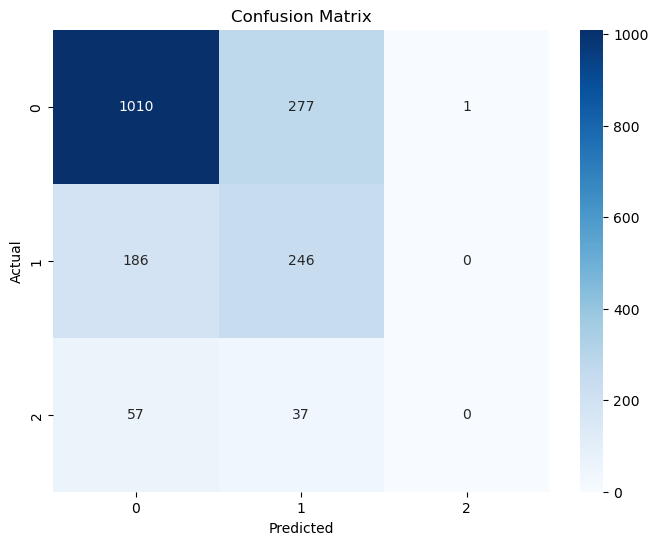

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

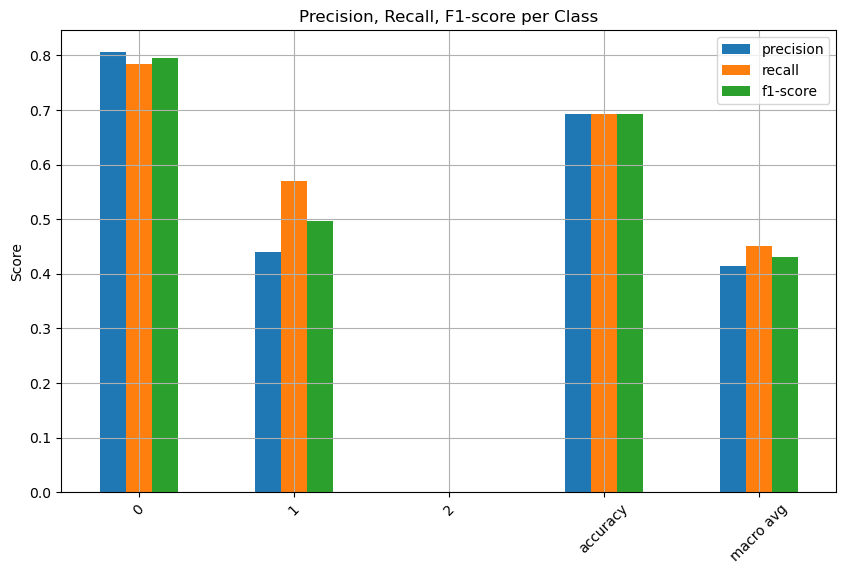

In [32]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(all_labels, all_preds, output_dict=True)
df = pd.DataFrame(report).transpose()

df.iloc[:-1, :3].plot(kind='bar', figsize=(10,6))
plt.title("Precision, Recall, F1-score per Class")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [33]:
avg_loss

0.7247176280147151

In [34]:
accuracy

0.6923925027563396

In [100]:
epoch_list = list(range(1, 20))

In [101]:
accuracy_list = [0.71,0.71,0.71,0.7133,0.7051,0.7117,0.7001,0.7084,0.7067,0.7051,0.7078,0.7084,0.7150,0.7018,0.7111,0.7034,0.7189,0.7150,0.6924]

In [102]:
loss_list = [0.7338,0.7235,0.6813,0.6795,0.6437,0.6444,0.6554,0.6362,0.6374,0.6502,0.6573,0.6467,0.6765,0.6737,0.6585,0.6710,0.6958,0.8067,0.7247]

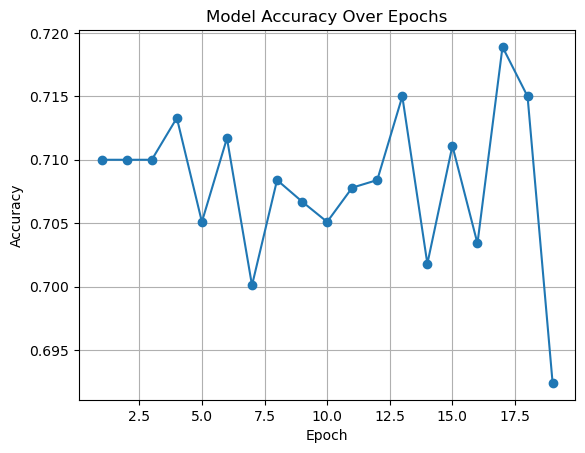

In [103]:
plt.plot(epoch_list, accuracy_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.grid(True)
plt.show()

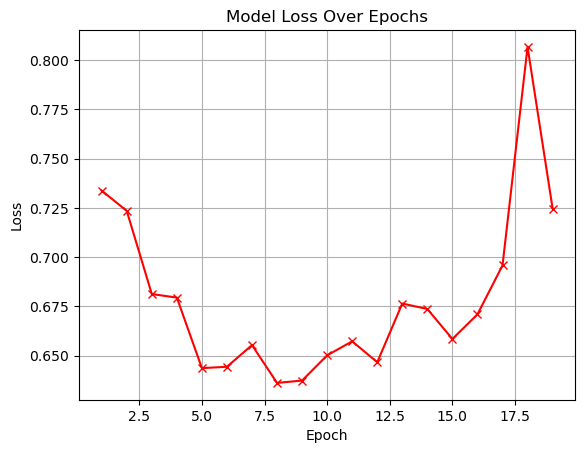

In [104]:
plt.plot(epoch_list, loss_list, marker='x', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss Over Epochs")
plt.grid(True)
plt.show()

In [68]:

import matplotlib.pyplot as plt
import random
%matplotlib inline
categories = df['type'].unique()
indices = random.sample(range(0, test_dataset.__len__()), 10)
print(indices)
images = torch.stack([test_dataset.__getitem__(i)[0] for i in indices])
# images = torch.from_numpy(images)
# print(images)
# # labels = [categories[int(test_dataset.__getitem__(i)[1])] for i in indices]
labels = [test_dataset.__getitem__(i)[1] for i in indices]
predictions = torch.argmax(model(images).cpu(), dim=1)
print(images.shape)
print(labels)
print(predictions)

[5369, 8, 4232, 2563, 2636, 4967, 5243, 693, 5008, 1128]
torch.Size([10, 3, 224, 224])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0])


In [54]:
df

,precision,recall,f1-score,support
0,0.806065,0.784161,0.794963,1288.000000
1,0.439286,0.569444,0.495968,432.000000
2,0.000000,0.000000,0.000000,94.000000
accuracy,0.692393,0.692393,0.692393,0.692393
macro avg,0.415117,0.451202,0.430310,1814.000000
weighted avg,0.676948,0.692393,0.682563,1814.000000


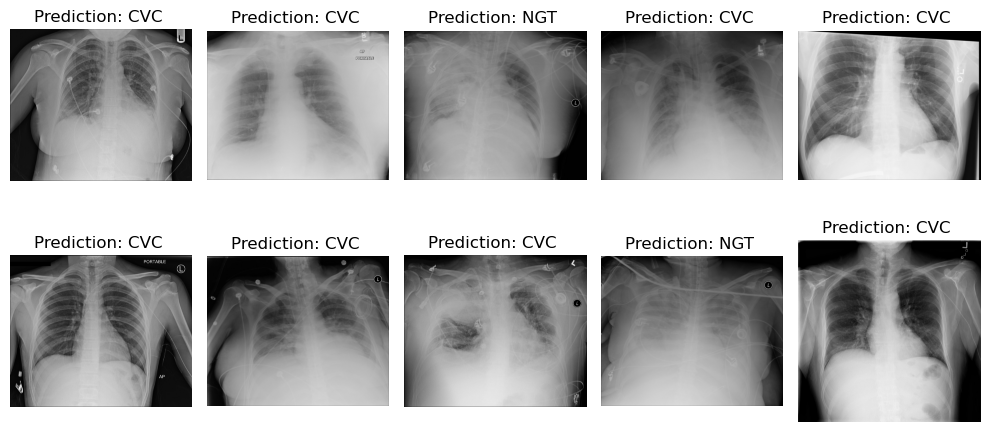

In [99]:

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.flatten()
for i in range(10):
  img = cv2.imread(test_dataset.image_paths[indices[i]])
  string = (test_dataset.image_paths[indices[i]])
  imageid = string.split("\\")[1].split('.jpg')[0]
  actual = df.loc[df['StudyInstanceUID'] == imageid]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i].imshow(img)
  title = f"Prediction: {categories[predictions[i]]}"

  # if labels is not None:
  #     title += f"\nTrue Label: {categories[labels[i]]}"

  axes[i].set_title(title)
  axes[i].axis('off')

plt.tight_layout()
plt.show()

In [121]:
#load pretrained resnet model
model = torchvision.models.resnet50(pretrained=True)
print(model)

#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,          
])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\toonb/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:15<00:00, 6.73MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [124]:
def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = (img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [127]:
img = Image.open(img).convert('RGB')
saliency(img,model)

AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [128]:
report = classification_report(all_labels, all_preds, output_dict=True)
df = pd.DataFrame(report).transpose()

In [129]:
df

,precision,recall,f1-score,support
0,0.806065,0.784161,0.794963,1288.000000
1,0.439286,0.569444,0.495968,432.000000
2,0.000000,0.000000,0.000000,94.000000
accuracy,0.692393,0.692393,0.692393,0.692393
macro avg,0.415117,0.451202,0.430310,1814.000000
weighted avg,0.676948,0.692393,0.682563,1814.000000


In [130]:
avg_loss

0.7247176280147151

In [131]:
accuracy

0.6923925027563396